# Some preliminary steps

In [490]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [491]:
sc.defaultParallelism

2

In [633]:
#wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [634]:
from __future__ import absolute_import
import json
import pprint
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import sys
import os

In [635]:
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [636]:
from pyspark.sql import *
from pyspark.sql.types import *

**Creating or Getting Spark Session and Take a look at the spark version** 

In [637]:
spark = SparkSession.builder.getOrCreate()
print(spark)

In [920]:
# Dropping any tables in SQL format 
#spark.sql(f"drop table creditcard")
#spark.sql(f"drop table creditcard_scaled")
#spark.sql(f"drop table weighted_creditcard")

In [921]:
#print(spark.catalog.listTables())

In [640]:
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket') # bucket information 
project = sc._jsc.hadoopConfiguration().get('fs.gs.project.id')  #project_id
input_directory = 'gs://{}/creditcard'.format(bucket) #input directory
#the data should be available under creditcard folder in your bucket.

# EDA

In [641]:
 #Reading the csv file into Spark DataFrame 
df_cc = spark.read.csv(os.path.join(input_directory,'creditcard.csv'), header=True, inferSchema=True)
df_cc.createOrReplaceTempView('creditcard')
#df_cc.write.saveAsTable("creditcard")

In [642]:
#Check the type of columns
df_cc.printSchema()

root
 |-- Time: decimal(10,0) (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double

In [643]:
#add it to the cache
print(spark.catalog.listTables())
#print(spark.catalog.isCached("creditcard"))
spark.catalog.cacheTable('creditcard')
print(spark.catalog.isCached("creditcard"))

[Table(name='creditcard', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]
True


In [644]:
print('Num of rows:', df_cc.count())
print('Columns:', df_cc.columns)
print('Num of columns:', len(df_cc.columns))
#print(df_cc.dtypes)

Num of rows: 284807
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Num of columns: 31


In [645]:
#number of rows 
#print(spark.table(tableName="creditcard").count())
#print(spark.table(tableName="creditcard").columns)

In [646]:
#df_cc.filter(df_cc['V1'].isNull()).show()
nan_counter = 0
for col in df_cc.columns: 
    if df_cc.filter(df_cc[col].isNull()).count() != 0:
        print(col)
        nan_counter += 1 
        print(df_cc.filter(df_cc[col].isNull()).show())
        
if nan_counter == 0: 
    print('No NaN values in the dataset')
    
else:
    print(nan_counter, 'rows with NaN values')
    

No NaN values in the dataset


In [647]:
#Alternative way of detecting NaN values
handydf_cc.isnull(ratio=True)

V1               0.0
V2               0.0
V3               0.0
V4               0.0
V5               0.0
V6               0.0
V7               0.0
V8               0.0
V9               0.0
V10              0.0
V11              0.0
V12              0.0
V13              0.0
V14              0.0
V15              0.0
V16              0.0
V17              0.0
V18              0.0
V19              0.0
V20              0.0
V21              0.0
V22              0.0
V23              0.0
V24              0.0
V25              0.0
V26              0.0
V27              0.0
V28              0.0
Class            0.0
Amount_Scaled    0.0
Time_Scaled      0.0
Name: missing(ratio), dtype: float64

In [648]:
#As it turns out we have a heavily imbalanaced dataset 

print('Num of No Frauds', df_cc.filter(df_cc['Class'] == 0).count()) # No Frauds
print('Num of Frauds', df_cc.filter(df_cc['Class'] == 1).count()) # Frauds
print('---------')
print('No Frauds', round(df_cc.filter(df_cc['Class'] == 0).count() / df_cc.count() * 100, 2), '% of the dataset')
print('Frauds', round(df_cc.filter(df_cc['Class'] == 1).count() / df_cc.count() * 100, 2), '% of the dataset')


Num of No Frauds 284315
Num of Frauds 492
---------
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [649]:
df_cc.describe(['Amount']).show()

+-------+------------------+
|summary|            Amount|
+-------+------------------+
|  count|            284807|
|   mean|  88.3496192509508|
| stddev|250.12010924018736|
|    min|               0.0|
|    max|          25691.16|
+-------+------------------+



In [650]:
df_cc.describe(['Time']).show()

+-------+------------------+
|summary|              Time|
+-------+------------------+
|  count|            284807|
|   mean|        94813.8596|
| stddev|47488.145954566906|
|    min|                 0|
|    max|            172792|
+-------+------------------+



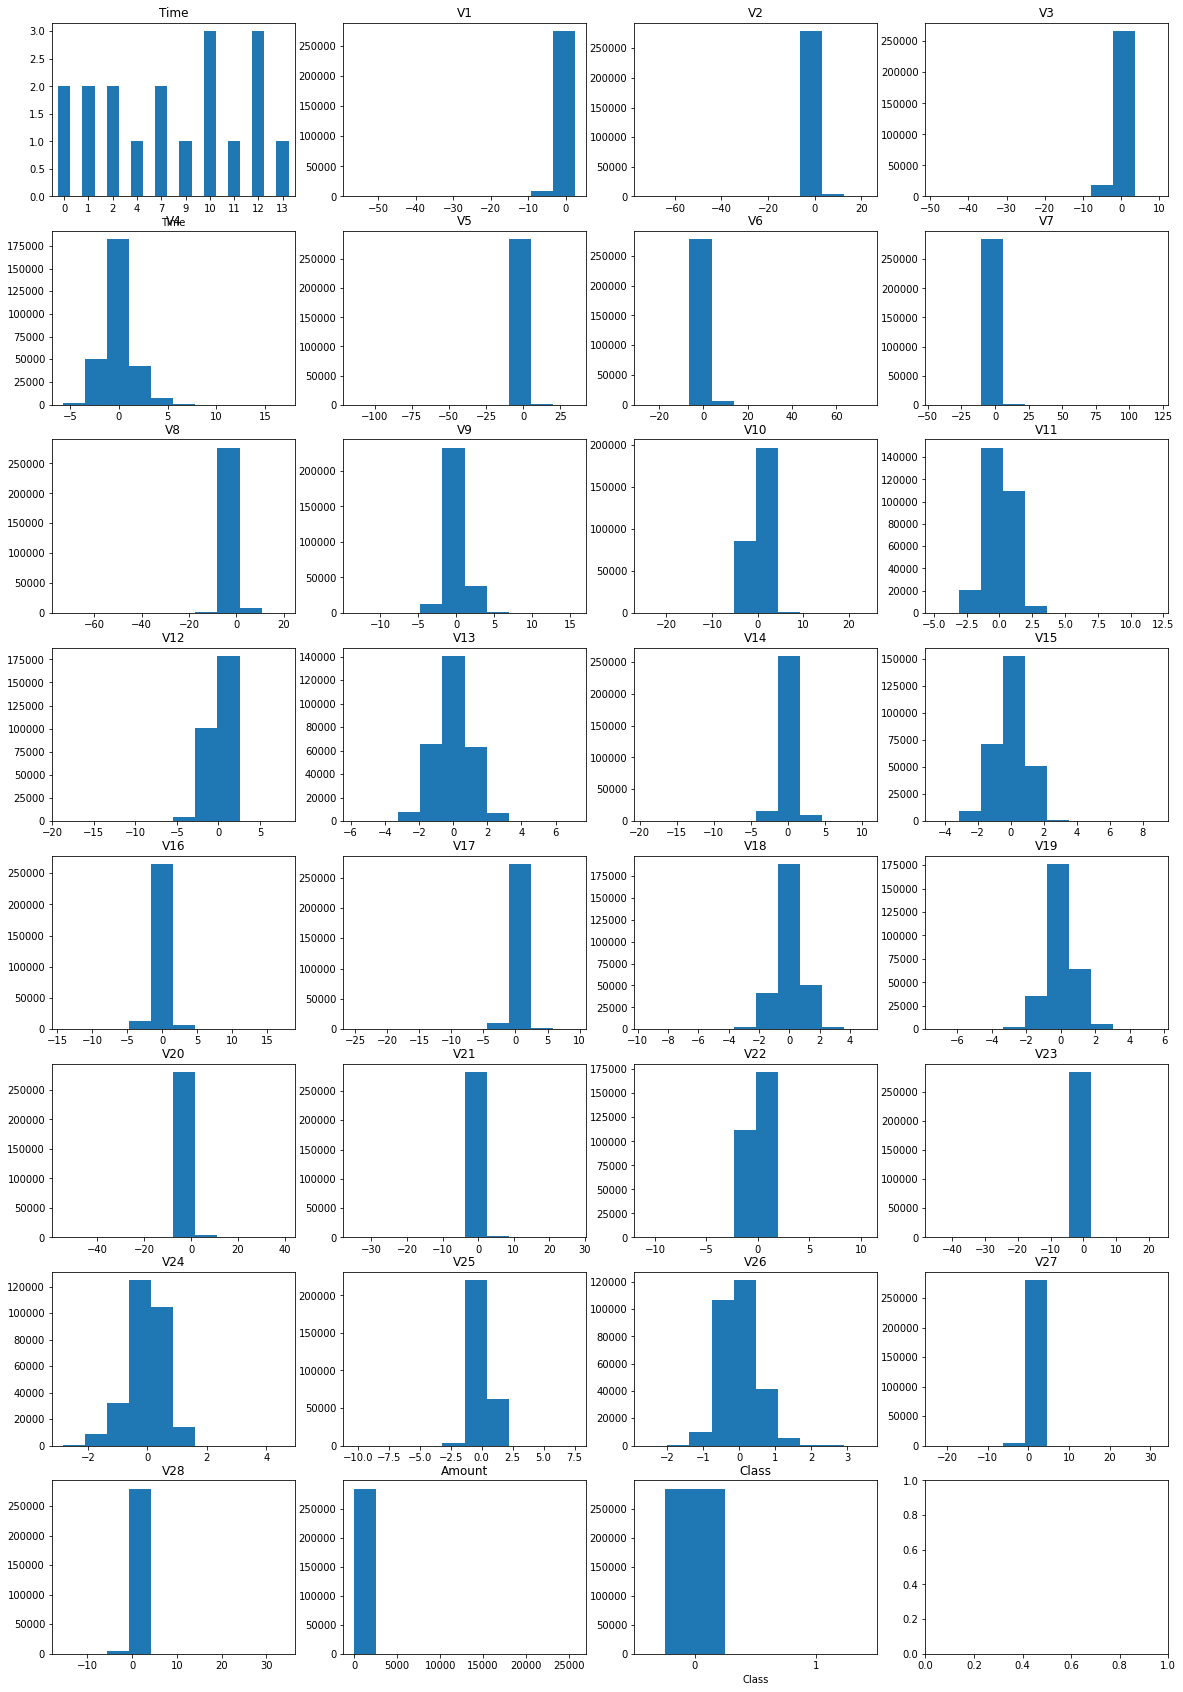

In [18]:
# Visualization libraries in Pyspark: pyspark_dist_explore, HandySpark,
from handyspark import *    #https://dvgodoy.github.io/handyspark/includeme.html#bringing-pandas-like-capabilities-to-spark-dataframes
handydf_cc = df_cc.toHandy()
colNum = 0

fig, axs = plt.subplots(8, 4, figsize=(20, 30))
for i in range(8):
    for j in range(4):
        handydf_cc.cols[df_cc.columns[colNum]].hist(ax = axs[i][j])
        colNum += 1
        if colNum == 31: 
            break

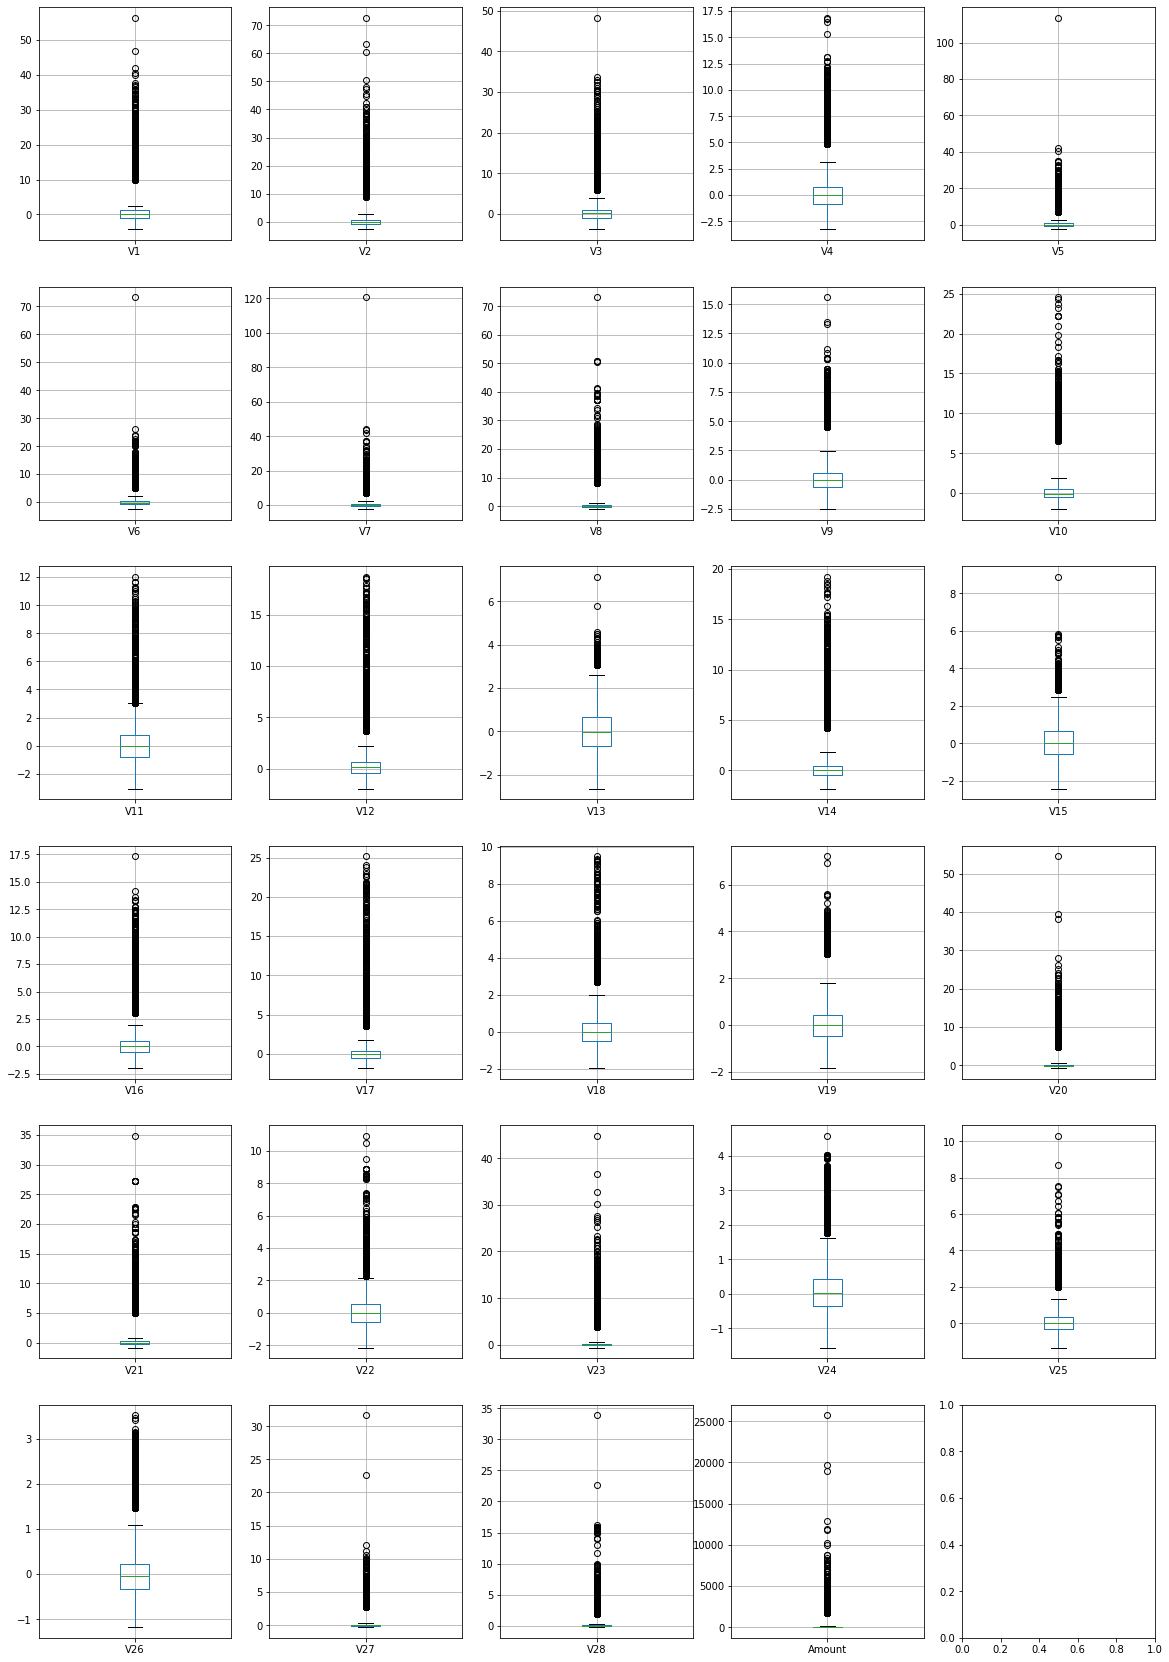

In [19]:
colNum = 1 #ColNum = 0 would be the Time variable

fig, axs = plt.subplots(6, 5, figsize=(20, 30)) # Boxplotting the numerical variables except Time and Class
for i in range(6):
    for j in range(5):
        #print(colNum)
        handydf_cc.cols[df_cc.columns[colNum]].boxplot(ax = axs[i][j])
        colNum += 1
        if colNum == 30: 
            break

In [651]:
#Rescale 'Amount' and 'Time' through Standardization. Put these rescaled variables into our dataset and pull out the original ones.

from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_cc_stats_Amount = df_cc.select(
    _mean(col('Amount')).alias('mean'),
    _stddev(col('Amount')).alias('std')
).collect()

mean_Amount = df_cc_stats_Amount[0]['mean']
std_Amount = df_cc_stats_Amount[0]['std']

df_cc = df_cc.withColumn("Amount_Scaled", (df_cc['Amount'] - mean_Amount) / std_Amount )
df_cc = df_cc.drop('Amount')

In [652]:
df_cc_stats_Time = df_cc.select(
    _mean(col('Time')).alias('mean'),
    _stddev(col('Time')).alias('std')
).collect()

mean_Time = df_cc_stats_Time[0]['mean']
std_Time = df_cc_stats_Time[0]['std']

df_cc = df_cc.withColumn("Time_Scaled", (df_cc['Time'] - mean_Time) / std_Time)
df_cc = df_cc.drop('Time')

In [653]:
print(df_cc_stats_Amount)
print(df_cc_stats_Time)

[Row(mean=88.3496192509508, std=250.12010924018736)]
[Row(mean=Decimal('94813.8596'), std=47488.145954566906)]


In [654]:
df_cc.createOrReplaceTempView('creditcard_Scaled')
print(spark.catalog.listTables())
spark.catalog.cacheTable('creditcard_Scaled')
print(spark.catalog.isCached("creditcard_Scaled"))

[Table(name='creditcard', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='creditcard_scaled', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]
True


In [655]:
# Checking "Visually" the scaled Time and Amount"
query = "SELECT Amount_Scaled, Time_Scaled FROM creditcard_Scaled LIMIT 100"
# Run the query
dfpd_cc = (spark.sql(query)).toPandas()
dfpd_cc.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Amount_Scaled,0.244964,-0.342474,1.160684,0.140534,-0.073403,-0.338556,-0.333278,-0.190107,0.019392,-0.338516,...,0.246083,0.004200,-0.246400,-0.329280,-0.214495,-0.133374,-0.323043,-0.273867,-0.240163,-0.289299
Time_Scaled,-1.996580,-1.996580,-1.996558,-1.996558,-1.996537,-1.996537,-1.996495,-1.996432,-1.996432,-1.996390,...,-1.995337,-1.995316,-1.995316,-1.995274,-1.995232,-1.995232,-1.995232,-1.995169,-1.995169,-1.995148


## We wanna assign higher weights to the fraud cases class==1 

In [656]:
colInputFeatures = copy.deepcopy(df_cc.columns)
colInputFeatures.remove('Class') 
colInputFeatures

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount_Scaled',
 'Time_Scaled']

In [657]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


# Make a VectorAssembler
assembler = VectorAssembler(inputCols = colInputFeatures, outputCol = 'features' )   #InputCols contains all the cols of the df_cc except 'Class'. We removed it in the cell above. 
data = assembler.transform(df_cc)

In [922]:
data.select('features').show(2, truncate = False) #the 'features' vector

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [659]:
data = data.withColumnRenamed('Class','label')  #Rename Class to label because the Pyspark ML Models will refer to Class as label. 

In [803]:
data

DataFrame[V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, label: int, Amount_Scaled: double, Time_Scaled: double, features: vector]

# Implementing ML Models (Logistic Regression and GBTC) 

## Defining the necessery functions for the ML pipeline

In [888]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [838]:
def fit_model(model, train, test, paramGrid = None,):
    '''
      Model fitting the selected model and paramgrid(optional)
      Input: model, train, test, paramgrid
      Output: fitted model, prediction on the test set
    '''
    pipeline = Pipeline(stages=[model])
    
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                          numFolds=5, seed = 42)
        
        fitmodel = crossval.fit(train)

    else:
        fitmodel = pipeline.fit(train)
    
    results = fitmodel.transform(test)
    
    return fitmodel, results



In [839]:
def val_evaluation(results):
    '''
      Using confusion matrix to calculate evaluation metrics
      Reminder of those metrics: 
        # accuracy: (TN+TP)/Total Predictions
        # precision: TP/(TP + FP)
        # recall: TP/(TP + FN)
        # f1 score: 2*(Recall * Precision) / (Recall + Precision)
        
      Input: prediction results
      Output: f1, accuracy, precision and recall score
      (Intermediary Output: P-R AUC, Confusion Matrix  
    '''
    predictionAndLabels = results.select(['prediction', 'label']).withColumn('label',col('label').cast(DoubleType())).rdd

    metrics = BinaryClassificationMetrics(predictionAndLabels)
    print("Area under PR = %s" % metrics.areaUnderPR) #plusz cucc
    cm=metrics.confusionMatrix().toArray()
    print(cm)
    
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[1][1])/(cm[1][1]+cm[0][1])
    recall=(cm[1][1])/(cm[1][1]+cm[1][0])
    f1 = 2*( (recall * precision) / (recall + precision) )
    return(round(f1,5), round(accuracy,5),round(precision,5),round(recall,5))

### Logit W/O classweighting 

In [840]:
lrParam = LogisticRegression()
paramGridLr = ParamGridBuilder() \
    .addGrid(lrParam.maxIter, [2,3])\
    .addGrid(lrParam.elasticNetParam, [0.0, 0.5, 1])\
    .addGrid(lrParam.threshold,[0.3,0.4,0.5,0.6])\
    .build()

In [841]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

lrmodel, lrresults = fit_model(lrParam, train, test, paramGrid = paramGridLr)

In [842]:
bp_index = lrmodel.avgMetrics.index(np.max(lrmodel.avgMetrics))
bp = paramGridLr[bp_index] 
print(bp) #hyperperameters of the best performed Logit on 5-fold CV 
print()
print(lrmodel.avgMetrics[bp_index]) #the best avg areaUnderPR of the logit with the best hyperparameters 

{Param(parent='LogisticRegression_92fd2d7b52ee', name='maxIter', doc='max number of iterations (>= 0).'): 3, Param(parent='LogisticRegression_92fd2d7b52ee', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_92fd2d7b52ee', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.3}

0.7500792312599742


In [843]:
print("Best LogisticRegression's metrics on the test set: f1_score, accuracy,precision,recall", val_evaluation(lrresults))

Area under PR = 0.7987193396627371
[[5.656e+04 9.000e+00]
 [2.300e+01 8.000e+01]]
Best LogisticRegression's metrics on the test set: f1_score, accuracy,precision,recall (0.83333, 0.99944, 0.89888, 0.7767)


### Logit W/ classweighting 

In [923]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType


#Iterating balancingRatiolist for different balancingRatio

data2 = data.select("*")

balancingRationlst = [data2.filter(data2['label'] == 1).count() / data2.count(), 0.01, 0.1, 0.3, 0.5, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61]
lr2 = LogisticRegression(maxIter=3.0, elasticNetParam=0.0, threshold=0.3) #Using the hyperparameter values given by the cross-validated logit models 


for bR in balancingRationlst:
    print("Balancing Ratio:", str(bR))
    print()
    calcWeight = udf(lambda x: 1 * bR if x == 0 else (1 * (1.0 - bR)), DoubleType() )
    data2 = data2.withColumn('classWeightCol', calcWeight('label'))
    trainW, testW = data2.randomSplit([0.8, 0.2], seed=42)
    lrmodelW, lrresultsW = fit_model(lr2.setWeightCol('classWeightCol'), trainW, testW)
    
    print("LogisticRegression: f1_score, accuracy,precision,recall", val_evaluation(lrresultsW))
    print('--------------------------------------------------------------------------------------------------------------------------------------------------')
    data2 = data2.drop('classWeightCol')
    print()
    

Balancing Ratio: 0.001727485630620034

Area under PR = 0.025113965378278202
[[5.2741e+04 3.8280e+03]
 [3.0000e+00 1.0000e+02]]
LogisticRegression: f1_score, accuracy,precision,recall (0.04962, 0.9324, 0.02546, 0.97087)
--------------------------------------------------------------------------------------------------------------------------------------------------

Balancing Ratio: 0.01

Area under PR = 0.27210645051796384
[[5.6357e+04 2.1200e+02]
 [1.5000e+01 8.8000e+01]]
LogisticRegression: f1_score, accuracy,precision,recall (0.43672, 0.99599, 0.29333, 0.85437)
--------------------------------------------------------------------------------------------------------------------------------------------------

Balancing Ratio: 0.1

Area under PR = 0.6866439018037886
[[5.6541e+04 2.8000e+01]
 [1.8000e+01 8.5000e+01]]
LogisticRegression: f1_score, accuracy,precision,recall (0.78704, 0.99919, 0.75221, 0.82524)
---------------------------------------------------------------------------------

Conclusion: The Best Logit model contains the following: 
  - hyperparameters: maxIter=3.0, elasticNetParam=0.0, threshold=0.3
  - Balancing ratio of either 0.56, 0.57, 0.58. (The original balancing ratio is 0.5. With 0.58 we need to give even a bigger weight to NoFraud class. An ECB article about the percentage of fraud transaction over the total transaction is around 0.04% and in our dataset this ratio is 0.17%. So in some sense it could be understandable why we should give an even bigger weight to NoFraud cases. 
  - The above mentioned ECB article: https://www.ecb.europa.eu/pub/cardfraud/html/ecb.cardfraudreport202008~521edb602b.en.html#:~:text=The%20value%20of%20card%20fraud%20therefore%20grew%20faster%20than%20the,2017%20to%200.037%25%20in%202018. 

### GBTClassifier 

In [915]:
gbtParam = GBTClassifier()

paramGridGBT = ParamGridBuilder() \
    .addGrid(gbtParam.maxIter, [10,20])\
    .addGrid(gbtParam.maxDepth, [3, 4])\
    .build()   

#Confess that I cheated in a way that I had chacked the case where maxIter values are small. They all give us much smaller P-R AUC. 
#Regarding maxDepth, in a not so large dataset like this, it's not really a winner strategy to have maxDepth = 5 or larger values. 

In [916]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

gbtmodel, gbtresults = fit_model(gbtParam, train, test, paramGrid=paramGridGBT)

In [917]:
bp_index = gbtmodel.avgMetrics.index(np.max(gbtmodel.avgMetrics))
bp = paramGridGBT[bp_index] 
print(bp) #hyperperameters of the best performed GBTClassifier on 5-fold CV 
print()
print(gbtmodel.avgMetrics[bp_index]) #the best avg areaUnderPR of the logit with the best hyperparameters 

{Param(parent='GBTClassifier_4e5b567e2da4', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='GBTClassifier_4e5b567e2da4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4}

0.8049524821845835


In [918]:
print("Best GBTClassifier's metrics on the test set: f1_score, accuracy,precision,recall", val_evaluation(gbtresults))

Area under PR = 0.8077933898625645
[[5.6561e+04 8.0000e+00]
 [2.3000e+01 8.0000e+01]]
Best GBTClassifier's metrics on the test set: f1_score, accuracy,precision,recall (0.8377, 0.99945, 0.90909, 0.7767)


Conclusion: The Best GBTClassifier model contains the following: 
 - hyperparameters: maxIter = 20, maxDepth = 4

## Summary

The Best Logit model's metrics:
- Best AVG CrossVal P-R AUC = 0.7500792312599742 (with Balancing Ratio = 0.5, didn't run for Balancing Ratio = 0.58) 
- P-R AUC = 0.7987193396627371
- f1_score, accuracy,precision,recall (0.83333, 0.99944, 0.89888, 0.7767)

The Best GBTClassifier model's metrics: 
- Best AVG CrossVal P-R AUC = 0.8049524821845835
- P-R AUC = 0.8077933898625645
- f1_score, accuracy,precision,recall (0.8377, 0.99945, 0.90909, 0.7767)

As we can see the hyperparamer-tuned GBTClassifier is the better model in every sense, meaning that in every relevant scores/metrics it overshadowed the hyperparameter-tuned Logit model by a small margin. However, both scores P-R AUC scores are quite formidable. As always, there are ways to improve this project, like having more plots (for example: AUC-plot, more data discovery plot. HandySpark is quite a solid package for visualizing, even for Big Data ML. This package kinda "pandasify" the spark dataframe but unlike pandas it's "spark-compatible" meaning that it will not break down when translating to Pandas-like dataframe. 


# Stopping Spark Session

In [924]:
spark.stop()